In [2]:
import pathlib
import pandas as pd
from matplotlib import pyplot as plt, ticker

EXPORT_PATH = pathlib.Path("showcase")

plt.style.use(EXPORT_PATH.joinpath("minimal.mplstyle"))

FIGURE_SIZE = (5, 3.5)
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWZYZ".lower()

In [8]:
def load_data():
    global results
    results = pd.read_csv("results.csv")
    results["response_time"] *= 1000

load_data()
results.sample(5)

,session,block,trial,cursor_position,timestamp,response_time,target_response,response,feedback,condition
7209,9,2,256,229,2024-02-23 12:09:28.790477,135.0911,n,h,negative,control
8940,12,1,132,103,2024-02-23 13:03:18.325145,87.9566,t,t,positive,control
8972,12,1,164,135,2024-02-23 13:03:22.380965,59.8971,n,n,positive,control
841,2,2,33,31,2024-02-21 08:31:13.756150,613.9387,p,p,positive,control
10714,17,1,49,35,2024-02-26 10:25:30.251302,92.6326,space,space,positive,control


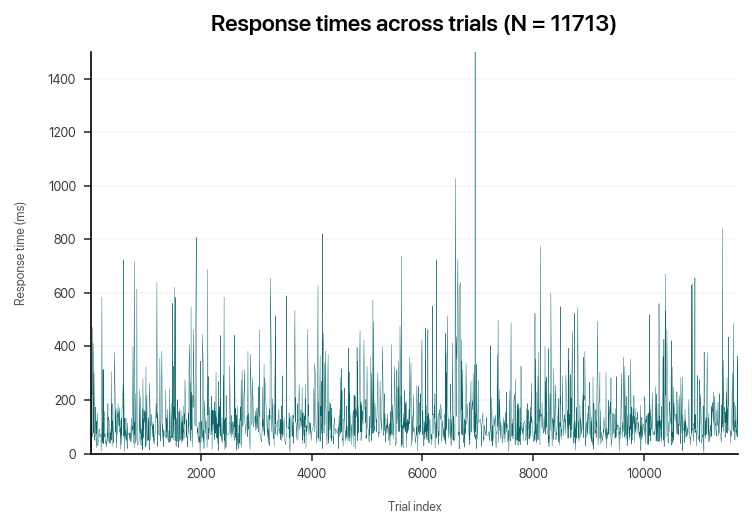

In [4]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)

downscaled = results.sample(min(len(results), 2000)).sort_index()
plt.plot(
    downscaled.index, 
    downscaled["response_time"],
    linewidth = 0.2,
)
plt.title(f"Response times across trials (N = {len(results)})")
plt.xlabel("Trial index")
plt.ylabel("Response time (ms)")
plt.ylim((0, 1500))
plt.tight_layout()

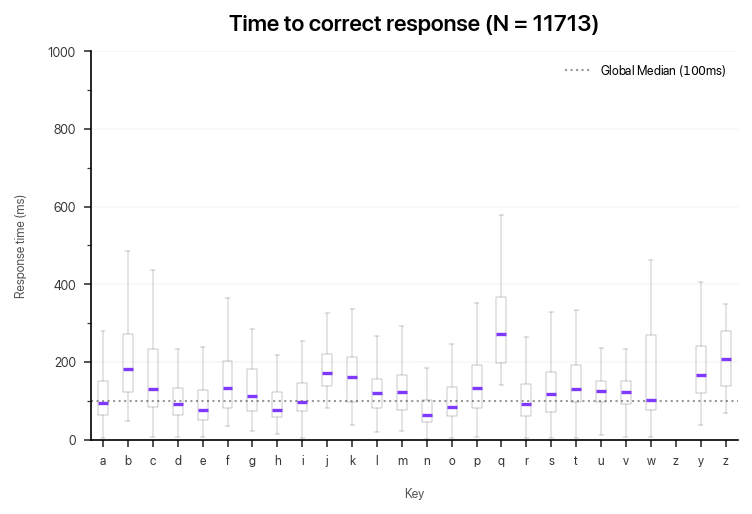

In [6]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)
time_to_type = results.groupby(["session", "block", "cursor_position", "target_response"])["response_time"].sum().reset_index()

for key, data in time_to_type[time_to_type["target_response"].isin(list(ALPHABET))].groupby("target_response"):
    outlines_alpha = 0.5
    plt.boxplot(
        data["response_time"],
        positions=[ord(key)],
        widths = 0.4,
        boxprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        whiskerprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        capprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        flierprops = dict(marker = "o", markersize = 1, alpha = outlines_alpha, markeredgecolor = "none"),
        medianprops = dict(linewidth = 1.6, color = "C2"),
    )
plt.axhline(
    y = time_to_type["response_time"].median(),
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
    label = f"""Global Median (${time_to_type["response_time"].median():.0f}$ms)"""
)
plt.legend(loc = "upper right")
plt.suptitle("")
plt.title(f"Time to correct response (N = {len(results)})")
plt.xlabel("Key")
plt.ylabel("Response time (ms)")
plt.xticks(range(97, 97 + 26), ALPHABET)
plt.yticks(range(0, 1000, 100))
plt.ylim((0, 1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.tight_layout()
# plt.savefig(EXPORT_PATH.joinpath("relative_difficulty_per_key.png"), dpi = 300)

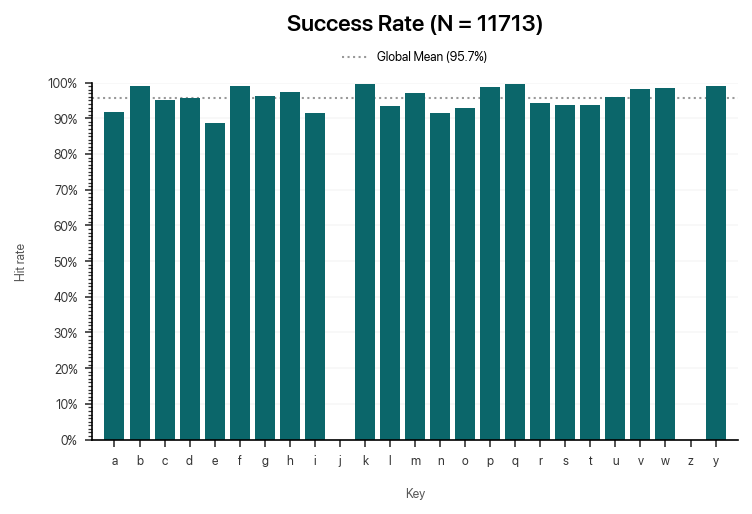

In [5]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)
incorrectly_typed = results[(results["response"].isin(list(ALPHABET.lower()))) & (results["response"] != results["target_response"])]
succes_rates = 1 - incorrectly_typed["response"].value_counts(normalize = True)

plt.bar(
    succes_rates.index.to_series().apply(ord), 
    succes_rates,
)

plt.axhline(
    y = succes_rates.mean(),
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
    label = f"""Global Mean ({succes_rates.mean():.1%})"""
)
plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.12))
plt.title(f"Success Rate (N = {len(results)})", pad = 25)
plt.suptitle("")
plt.xlabel("Key")
plt.ylabel("Hit rate")
plt.xticks(range(97, 97 + 26), ALPHABET)
plt.margins(x = 0.02)
plt.ylim((0, 1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
plt.tight_layout()

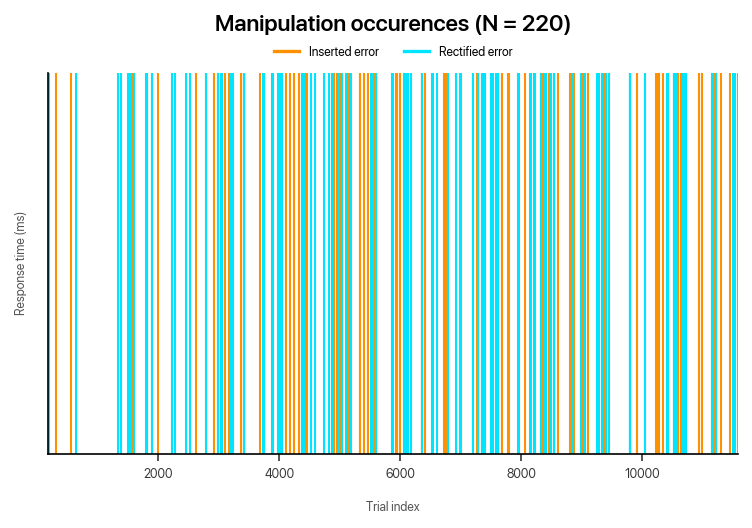

In [6]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)

inserted_error_trials = results[(results["response"] == results["target_response"]) & (results["feedback"] == "negative")]
plt.plot([], [], color = "C3", label = "Inserted error")
for idx in inserted_error_trials.index:
    plt.axvline(idx, color = "C3", linewidth = 1)
rectified_error_trials = results[(results["response"] != results["target_response"]) & (results["feedback"] == "positive")]
plt.plot([], [], color = "C5", label = "Rectified error")
for idx in rectified_error_trials.index:
    plt.axvline(idx, color = "C5", linewidth = 1)

plt.title(f"Manipulation occurences (N = {len(inserted_error_trials) + len(rectified_error_trials)})", pad = 20)
plt.xlabel("Trial index")
plt.ylabel("Response time (ms)")
plt.yticks([])
plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.1), ncol = 2)
plt.tight_layout()

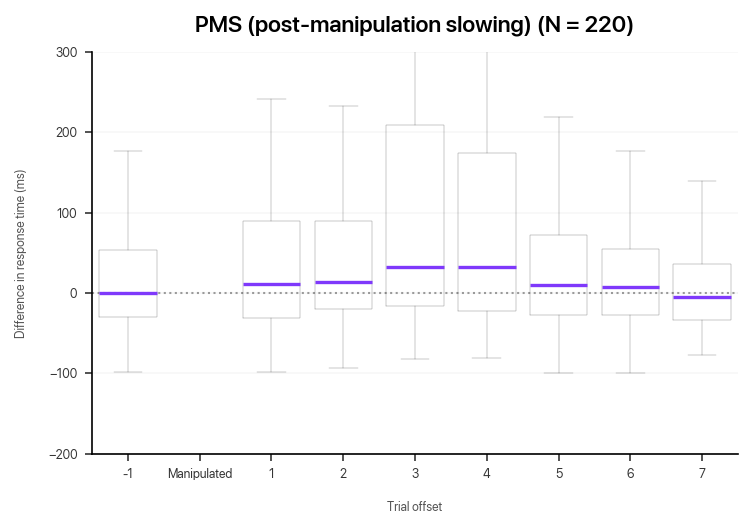

In [5]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)

manipulated = results[results["condition"] != "control"]
immediately_preceding_manipulations = results["response_time"].loc[[trial_idx - 1 for trial_idx in manipulated.index]]
offset_range = range(-1, 8)
for trial_offset in offset_range:
    if trial_offset == 0:
        continue
    response_times = results["response_time"].loc[[trial_idx + trial_offset for trial_idx in manipulated.index if trial_idx + trial_offset in results.index.values]]
    outlines_alpha = 0.5
    plt.boxplot(
        response_times - immediately_preceding_manipulations.median(),
        positions=[trial_offset],
        widths = 0.8,
        boxprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        whiskerprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        capprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        flierprops = dict(marker = "o", markersize = 1, alpha = outlines_alpha, markeredgecolor = "none"),
        medianprops = dict(linewidth = 1.6, color = "C2"),
    )
plt.axhline(
    y = 0,
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
)
plt.xticks(offset_range, ["Manipulated" if offset == 0 else offset for offset in offset_range])

plt.title(f"PMS (post-manipulation slowing) (N = {len(manipulated)})")
plt.xlabel("Trial offset")
plt.ylabel("Difference in response time (ms)")
plt.ylim((-200, 300))
plt.tight_layout()
# plt.savefig(EXPORT_PATH.joinpath("post_manipulation_slowing.png"), dpi = 300)

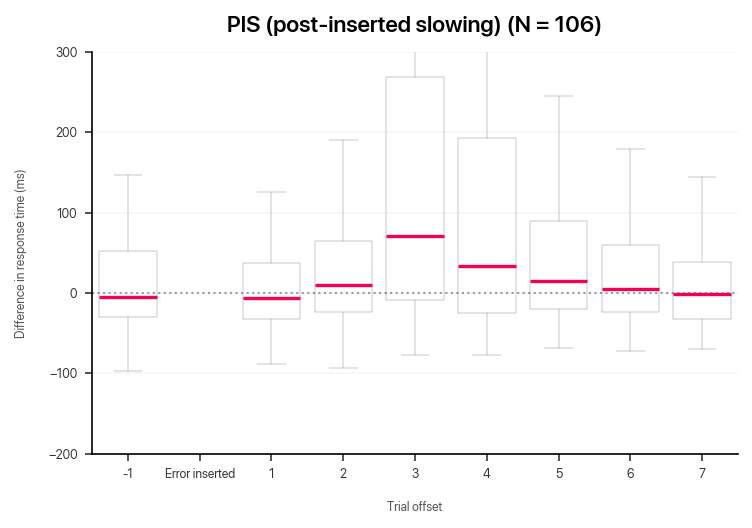

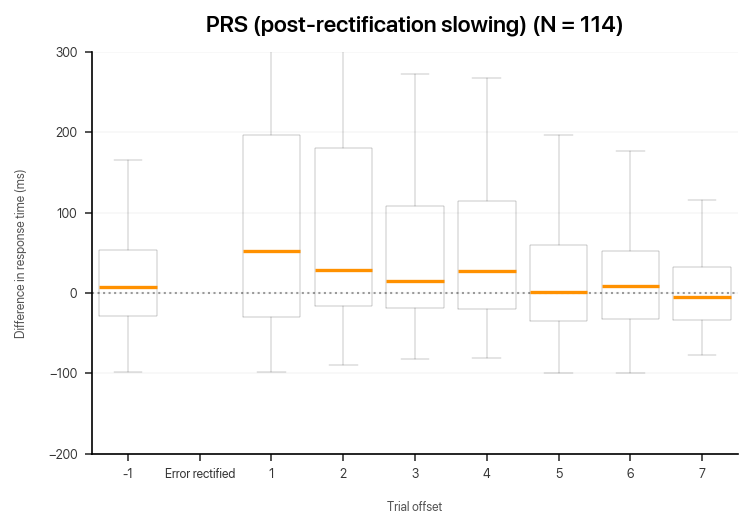

In [8]:
plt.figure(figsize=FIGURE_SIZE)

inserted_errors = results[results["condition"] == "error inserted"]
offset_range = range(-1, 8)
for trial_offset in offset_range:
    if trial_offset == 0:
        continue
    response_times = results["response_time"].loc[[trial_idx + trial_offset for trial_idx in inserted_errors.index if trial_idx + trial_offset in results.index.values]]
    outlines_alpha = 0.5
    plt.boxplot(
        response_times - immediately_preceding_manipulations.median(),
        positions=[trial_offset],
        widths = 0.8,
        boxprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        whiskerprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        capprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        flierprops = dict(marker = "o", markersize = 1, alpha = outlines_alpha, markeredgecolor = "none"),
        medianprops = dict(linewidth = 1.6, color = "C7"),
    )
plt.axhline(
    y = 0,
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
)
plt.xticks(offset_range, ["Error inserted" if offset == 0 else offset for offset in offset_range])

plt.title(f"PIS (post-inserted slowing) (N = {len(inserted_errors)})")
plt.xlabel("Trial offset")
plt.ylabel("Difference in response time (ms)")
plt.ylim((-200, 300))
plt.tight_layout()

plt.figure(figsize=FIGURE_SIZE)

rectified_errors = results[results["condition"] == "error rectified"]
offset_range = range(-1, 8)
for trial_offset in offset_range:
    if trial_offset == 0:
        continue
    response_times = results["response_time"].loc[[trial_idx + trial_offset for trial_idx in rectified_errors.index if trial_idx + trial_offset in results.index.values]]
    outlines_alpha = 0.5
    plt.boxplot(
        response_times - immediately_preceding_manipulations.median(),
        positions=[trial_offset],
        widths = 0.8,
        boxprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        whiskerprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        capprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        flierprops = dict(marker = "o", markersize = 1, alpha = outlines_alpha, markeredgecolor = "none"),
        medianprops = dict(linewidth = 1.6, color = "C3"),
    )
plt.axhline(
    y = 0,
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
)
plt.xticks(offset_range, ["Error rectified" if offset == 0 else offset for offset in offset_range])

plt.title(f"PRS (post-rectification slowing) (N = {len(rectified_errors)})")
plt.xlabel("Trial offset")
plt.ylabel("Difference in response time (ms)")
plt.ylim((-200, 300))
plt.tight_layout()

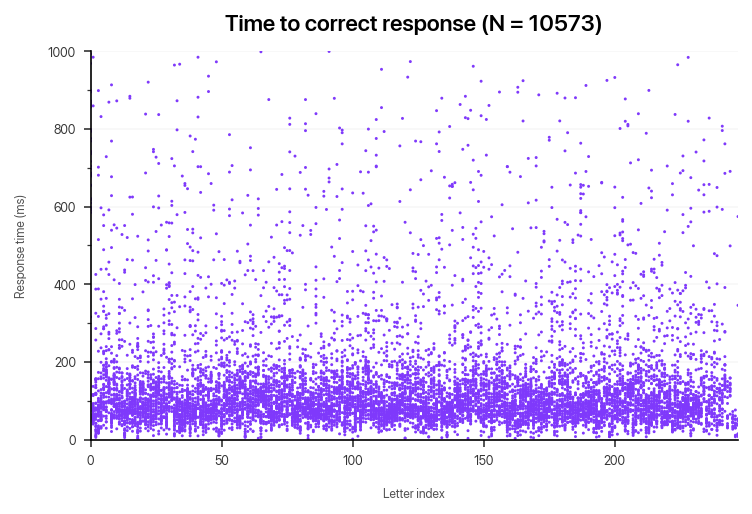

In [9]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)
plt.scatter(
    time_to_type["cursor_position"], 
    time_to_type["response_time"],
    marker = "o",
    s = 2,
    color = "C2",
    edgecolor = "none",
)
plt.suptitle("")
plt.title(f"Time to correct response (N = {len(time_to_type)})")
plt.xlabel("Letter index")
plt.ylabel("Response time (ms)")
plt.yticks(range(0, 1000, 100))
plt.ylim((0, 1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.tight_layout()